<a href="https://colab.research.google.com/github/Sanjayso27/RL_Frozen_Lake/blob/main/Frozen_lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Frozen Lake Problem Description:

> Imagine there is a frozen lake stretching from your home to your office; you have to walk on the frozen lake to reach your office. But oops! There are holes in the frozen lake so you have to be careful while walking on the frozen lake to avoid getting trapped in the holes. [[src](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788836524/3/ch03lvl1sec32/solving-the-frozen-lake-problem)]

![frozen-lake](https://static.packt-cdn.com/products/9781788836524/graphics/49f3e058-2f32-40e8-9992-b53d1f57d138.png)


Two task you have to do here:

*   Implement a frozen lake scenario given the inputs, number of holes (M) and size of the lake (N) (Assume the lake is square). Starting point will be (0, 0) and goal will be to reach at (N-1, N-1)
*   Implemenat Q-learning method to learn a path from start to goal.
*   Use the following reward scheme: 50 points on reaching the goal, -50 points on stepping on a hole.

#### Q-learning
Recall from the lecture video that `Q[state, action]` gives you an action state pair to get an optimal policy. Recall the Q-Loss from the lecture video i.e:
> $E = ||r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a)||^2$

Use gradient descent to minimise $E$ and work out a learning rule for $Q(s, a)$. 
> Take $\max_{a'} Q(s', a')$ and $r$ to be independent of $Q(s, a)$.


### Defining important functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from numpy.random import choice as randC
from numpy.random import uniform as randU

In [3]:
ActionMap = ['Up', 'Right', 'Down', 'Left']

In [4]:
def get_board(N, M):
  # should return an N x N size frozen lake - board with M randomle placed holes.
  # use 'S' representation for starting point
  # use 'G' representation for goal point
  # use 'H' representation for holes
  # use 'F' for frozen lakes
  # use 'C' for displaying agents current position on the board.
  # Refer the representation from the image shown above

  # Write your code here ----------
  H = randC(N*N-2, M, replace=False) + 1      
  
  row = ['F' for i in range(N)]
  board = [row for i in range(N)]
  board = np.array(board, dtype=str)

  for i in H:
      board[int(i/N)][int(i%N)] = 'H'
  
  board[0, 0] = 'S'
  board[N-1, N-1] = 'G'
  # -------------------------------

  return board

In [5]:
def get_reward(board, N, M):
  # should return an N x N size reward table for the generated frozen lake scenario
  # use 50 reward for 'G' point
  # use -50 reward for 'H' point
  # o for rest.

  # Write your code here ----------

  reward = np.zeros(board.shape).astype('int')

  for i in range(board.shape[0]):
    for j in range(board.shape[1]):
      if(board[i][j] == 'H'):
        reward[i][j] = -50
      if(board[i][j] == 'G'):
        reward[i][j] = 50

  # -------------------------------

  return reward

In [6]:
class FrozenLake:
  def __init__(self, N, M):
    # Recall python class, this function is called when you first initialise the class
    # Should intialise the board and reward table based on the reward scheme
    # Select M numbers of holes randomly

    self.board = get_board(N, M)
    self.init_board = copy.deepcopy(self.board)
    self.reward = get_reward(self.board, N, M)
    self.state = (0, 0)
    self.board[self.state] = 'C'
    self.finish = 0
    self.N = N

  def reset(self):
    # should reset the env with board to initial state
    # hint: set self.state at 0, 0 and use self.init_board to reset self.board

    # Write your code here ----------
    self.state = (0, 0)
    self.board = copy.deepcopy(self.init_board)
    self.board[self.state] = 'C'
    # -------------------------------
    self.finish = 0

    return self.state
  
  def step(self, action):
    # ===== Action Table =========
    #     0 -- UP
    #     1 -- RIGHT
    #     2 -- DOWN
    #     3 -- LEFT
    # perform the given action and get update the  self.state, get reward, and update the self.board according to new state
    # update the self.board means update the new position with 'C' and replace previous position with {'S', 'F', 'G'} which is actually there according to the self.init_board

    # Write your code here ----------
    self.board[self.state] = self.init_board[self.state]

    if action == 0: self.state = (self.state[0] - 1, self.state[1])
    elif action == 1: self.state = (self.state[0], self.state[1] + 1)
    elif action == 2: self.state = (self.state[0] + 1, self.state[1])
    elif action == 3: self.state = (self.state[0], self.state[1] - 1)

    reward = self.reward[self.state]

    self.board[self.state] = 'C'
    N = self.N
    # -------------------------------
    
    # status to check if you reached your goal
    if self.state == (N-1, N-1):
        self.finish = 1
        
    return self.state, reward, self.finish
  
  def get_random_action(self):
    # ===== Action Table =========
    #     0 -- UP
    #     1 -- RIGHT
    #     2 -- DOWN
    #     3 -- LEFT
    # should return a possible random action out of the four
    # hint: note that when you are around the corner or sides of the board not all four action will be available for you

    # Write your code here ----------
    valid_actions = [0, 1, 2, 3]

    if self.state[0] == 0: valid_actions.remove(0)
    if self.state[0] == self.N-1: valid_actions.remove(2)
    if self.state[1] == 0: valid_actions.remove(3)
    if self.state[1] == self.N-1: valid_actions.remove(1)
    # -------------------------------

    action = randC(valid_actions)

    return action    
      
  def display(self):
    print(self.board)

### Environment creation and learning

In [7]:
def explore_exploit(env, Q, state, episode):
  # Notice that if you always select your new action based on maximum Q-value you will never get to see any new path right?
  # You have to explore the environment to know new paths
  # Write your code here to randomly select whether you want to explore or exploit
  # The probability of exploration should be exp(-episode*5e-4)
  # for exploration get some random action
  # for exploitation get action based on max Q value

  # Write your code here ----------
  exploit = randU(0,1)
  if exploit > np.exp(-episode*5e-4):
      action = np.argmax(Q[state])
  else:
      action = env.get_random_action()
  # -------------------------------

  return action

In [8]:
def init_env_and_learn(N=6, M=12, gamma=0.8, lr=0.8):
  # gamma: gamma param of total discounted reward
  # lr: learning rate for Q updates
  # N = grid size of frozen lake wil be N x N
  # M = Number of holes
  # returns env, Q-function, rewards

  env = FrozenLake(N, M)
  Q = np.zeros((N, N, 4))
  
  Q[0, :, 0] = -1e8     # To avoid invalid 'UP' action
  Q[N-1, :, 2] = -1e8   # To avoid invalid 'Down' action
  Q[:, 0, 3] = -1e8     # To avoid invalid 'LEFT' action
  Q[:, N-1, 1] = -1e8   # To avoid invalid 'RIGHT' action

  total_episodes = 3000 # i.e. the number of times your RL agent will run through the board.
  max_steps = N*N*3 # maximum number of steps to perform

  rewards = []
  for episode in range(total_episodes):
    state = env.reset()
    total_rewards = 0

    for step in range(max_steps):
      action = explore_exploit(env, Q, state, episode)

      # Write your code here ----------------------------------------------------------
      # Should perform the action get reward, new_state, finish status and update the Q value
      new_state, reward, finish = env.step(action)
      Q[state][action] = Q[state][action] + lr*(reward + gamma*np.max(Q[new_state]) - Q[state][action])
      # -------------------------------------------------------------------------------

      total_rewards += reward
      state = new_state
      
      if finish == 1: 
          break

    rewards.append(total_rewards)

  return env, Q, rewards

In [10]:
def travel_path(env, Q, show_display=False):
  # write a function to display a sequence of path performed using the learned Q-values
  # show initial and final frozen lake board 
  # to perform an action at a state simply take max of Q at that state

  # Write your code here ----------
  state = env.reset()
  finish = 0
  for step in range(3*env.N*env.N):
    action = np.argmax(Q[state])
    state, reward, finish = env.step(action)

    if show_display:
      print('--------------------------------')
      print(' Action: ', ActionMap[action], ' | Step No.: ', step+1, ' ')
      print('--------------------------------')
      env.display()
      print()

    if finish:
        break

  if finish == 0 and show_display:
    print('Sorry No Solution Found!!')

  # -------------------------------

  return finish

### Use N = 6, M = 10 and learn the models for following sets of gamma and lr:

*   `(gamma, lr) = (0.8, 0.8)`
*   `(gamma, lr) = (0.95, 0.8)`
*   `(gamma, lr) = (0.6, 0.8)`
*   `(gamma, lr) = (0.8, 0.95)`
*   `(gamma, lr) = (0.8, 0.1)`

Plot rewards vs episode for each of them and compare.



| gamma: 0.8 | lr: 0.8 |
time to train: 4.037098407745361, average reward: -207.61666666666667
| gamma: 0.95 | lr: 0.8 |
time to train: 3.7269556522369385, average reward: -152.63333333333333
| gamma: 0.6 | lr: 0.8 |
time to train: 4.47450852394104, average reward: -199.3
| gamma: 0.8 | lr: 0.95 |
time to train: 3.7779126167297363, average reward: -197.23333333333332
| gamma: 0.8 | lr: 0.1 |
time to train: 11.699333190917969, average reward: -545.1666666666666


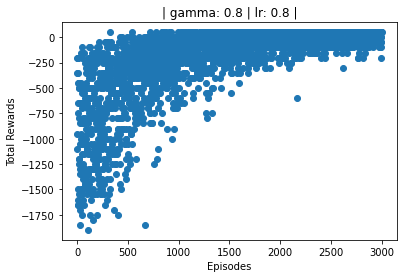

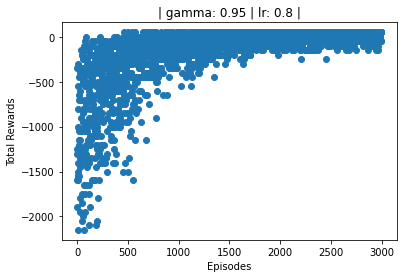

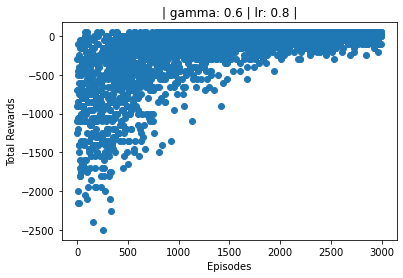

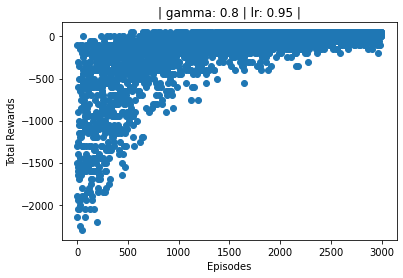

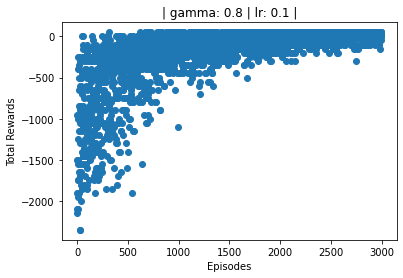

In [13]:
import time
# Write your code here ----------
for (gamma, lr) in [(0.8, 0.8), (0.95, 0.8), (0.6, 0.8), (0.8, 0.95), (0.8, 0.1)]:
  print("| gamma: " + str(gamma) + " | lr: " + str(lr) + " |")
  soln_exist = 0
  start = time.time()
  env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=gamma, lr=lr)
  end = time.time()

  print("time to train: {}, average reward: {}".format(end-start, sum(rewards)/len(rewards)))
  soln_exist = travel_path(env, Q)

  while soln_exist == 0:
    env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=gamma, lr=lr)
    soln_exist = travel_path(env, Q)

  rewards = np.array(rewards)

  plt.figure()
  plt.scatter(range(len(rewards)), rewards)
  plt.ylabel('Total Rewards')
  plt.xlabel('Episodes')
  plt.title("| gamma: " + str(gamma) + " | lr: " + str(lr) + " |")

### Use N = 6, M = 10 and learn a models with (gamma, lr) = (0.8, 0.8)
After learning the model, display a path traveled from source to goal.

In [ ]:
# Write your code here ----------
env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=0.8, lr=0.8)
soln_exist = travel_path(env, Q, show_display=True)
# -------------------------------

--------------------------------
 Action:  Down  | Step No.:  1  
--------------------------------
[['S' 'H' 'F' 'F' 'F' 'F']
 ['C' 'H' 'F' 'F' 'H' 'F']
 ['F' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'F' 'F']
 ['H' 'H' 'F' 'H' 'H' 'F']
 ['F' 'F' 'H' 'F' 'F' 'G']]

--------------------------------
 Action:  Down  | Step No.:  2  
--------------------------------
[['S' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F']
 ['C' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'F' 'F']
 ['H' 'H' 'F' 'H' 'H' 'F']
 ['F' 'F' 'H' 'F' 'F' 'G']]

--------------------------------
 Action:  Right  | Step No.:  3  
--------------------------------
[['S' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F']
 ['F' 'C' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'F' 'F']
 ['H' 'H' 'F' 'H' 'H' 'F']
 ['F' 'F' 'H' 'F' 'F' 'G']]

--------------------------------
 Action:  Right  | Step No.:  4  
--------------------------------
[['S' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F']
 ['F' 'F' 'C' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'F' 'F']
 [

Reference:[BCS_Workshop_Apr_20](https://github.com/bcs-iitk/BCS_Workshop_Apr_20)